In [1]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource

In [3]:
startDateStr = '2014/12/31'
endDateStr = '2017/12/31'
cachedFolderName = '/mnt/c/Users/kaagrawa/Desktop/HARSHIT_NITT/Eco_project/yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['^GSPC','DOW','MSFT']
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']
# log returns
lrets = np.log(data/data.shift(1)).dropna()

Processing data for stock: ^GSPC
Processing data for stock: DOW
Processing data for stock: MSFT
20% done...
40% done...
60% done...
80% done...


In [4]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

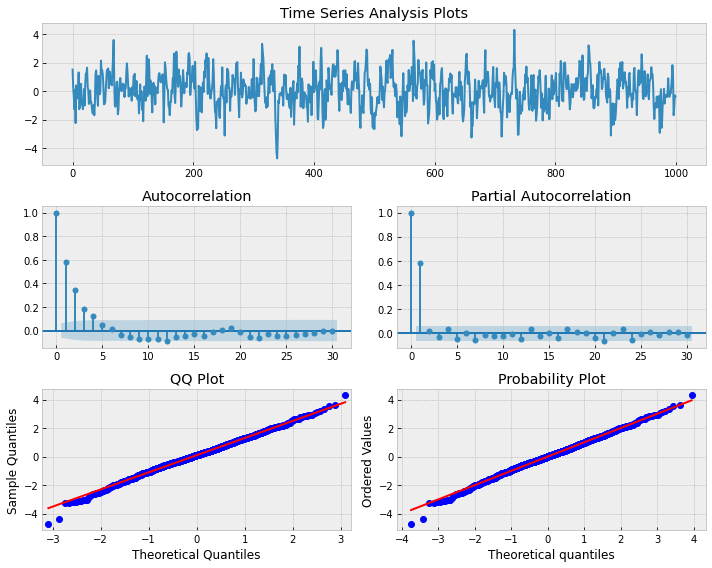

In [5]:
# Simulate an AR(1) process with a = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

In [6]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = sm.tsa.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = sm.tsa.AR(x).select_order( maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: %3.5f | order_estimate %s'%(mdl.params, est_order))
print('\ntrue alpha = %s | true order = %s'%(a, true_order))


alpha estimate: 0.58227 | order_estimate 1

true alpha = 0.6 | true order = 1


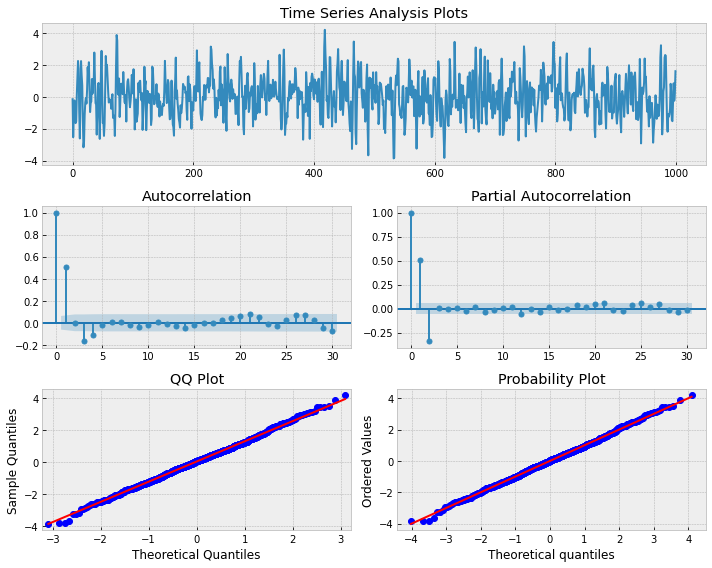

In [7]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

In [8]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order( maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: %3.4f %3.4f | order estimate %s'%(mdl.params[0],mdl.params[1],est_order))



coef estimate: 0.6760 -0.3393 | order estimate 2


In [10]:
mdl = smt.AR(ar2).fit()
print ('Parameters')
print (mdl.params)
print ('Standard Error')
print (mdl.bse)

Parameters
[ 3.57345632e-02  6.67118523e-01 -3.40041205e-01  9.01909128e-03
 -1.11520048e-02  2.14435279e-02 -4.83381895e-02  3.28287551e-02
 -2.38531001e-02 -4.90031065e-04 -3.12735473e-02  5.21112625e-02
 -5.85303137e-02  2.17108859e-02 -5.58739239e-02  2.79663351e-02
 -6.45697812e-03 -2.90269682e-02  3.79624698e-02  1.12370300e-02
  2.54545125e-03  5.79634021e-02]
Standard Error
[0.03330767 0.03229192 0.03882052 0.04032568 0.04032737 0.04031148
 0.04030305 0.04029053 0.04027444 0.04025271 0.04022384 0.04018031
 0.0402171  0.04026555 0.04027908 0.04028844 0.04027529 0.04028007
 0.04028697 0.04034915 0.03870137 0.03212717]
